Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0511
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0049
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0043
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0035
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0029
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0027
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0026
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0023
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0021
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0021
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0021
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0020
Epoch 13/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0017
Epoch 14/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0019
Epoch 15/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0018
Epoc

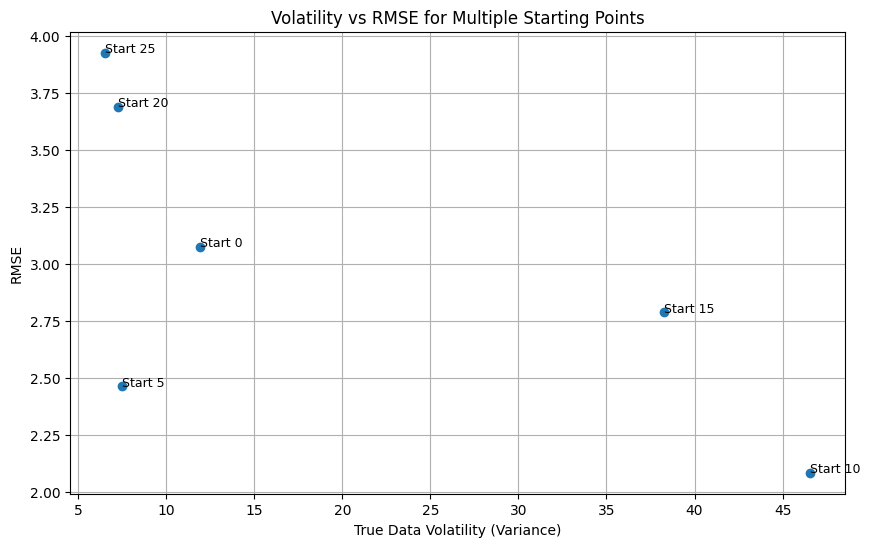

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU

# Function to create lag features and rolling statistics
def create_lag_features(data, lags):
    for lag in range(1, lags + 1):
        data[f'lag_{lag}'] = data['Close'].pct_change(lag)  # Percentage change
    data['rolling_mean'] = data['Close'].rolling(window=5).mean()
    data['rolling_std'] = data['Close'].rolling(window=5).std()
    return data

# Function to split the dataset
def split_data(df, training_period, train_ratio=0.8):
    # Create lag features and rolling statistics
    df = create_lag_features(df, training_period)
    df.dropna(inplace=True)  # Remove rows with NaN values

    # Scale features
    feature_scaler = StandardScaler()
    scaled_features = feature_scaler.fit_transform(df.drop(columns=['Close']))
    scaled_data = pd.DataFrame(scaled_features, columns=df.drop(columns=['Close']).columns, index=df.index)
    scaled_data['Close'] = df['Close']  # Keep original target for splitting

    # Scale the target variable
    target_scaler = StandardScaler()
    scaled_data['Close'] = target_scaler.fit_transform(df['Close'].values.reshape(-1, 1)).ravel()

    # Split data
    split_idx = int(len(df) * train_ratio)
    train_data = scaled_data.iloc[:split_idx]
    test_data = scaled_data.iloc[split_idx:]

    # Separate features and targets
    X_train = train_data.drop(columns=['Close'])
    y_train = train_data['Close']
    X_test = test_data.drop(columns=['Close'])
    y_test = test_data['Close']

    return X_train, y_train, X_test, y_test, test_data.index, feature_scaler, target_scaler

# Function to train the LSTM model
def train_lstm(X_train, y_train, input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    # model.add(LSTM(units=50, return_sequences=False))
    model.add(GRU(units=50, return_sequences=False))  # Add GRU layer
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
    model.fit(X_train, y_train.values, epochs=50, batch_size=32, verbose=1)
    return model

# Function to evaluate and visualize predictions for multiple starting points
def evaluate_multiple_start_points(model, X_test, y_test, test_index, n_days_to_predict, num_start_points, feature_scaler, target_scaler):
    errors = []
    volatilities = []

    start_indices = range(0, 30, 5)  # Manually specify starting indices
    for start_idx in start_indices:
        end_idx = start_idx + n_days_to_predict

        # Ensure the model always gets the past 15 days of data
        context_idx = start_idx - 15
        X_context = X_test.iloc[context_idx:start_idx]  # Past 15 days
        X_sub = X_test.iloc[start_idx:end_idx]
        y_true = y_test.iloc[start_idx:end_idx]

        # Reshape for LSTM input
        X_sub = X_sub.values.reshape((X_sub.shape[0], X_sub.shape[1], 1))

        # Predict and invert scaling for the target
        predictions = model.predict(X_sub)
        predictions = target_scaler.inverse_transform(predictions.reshape(-1, 1)).ravel()
        y_true_unscaled = target_scaler.inverse_transform(y_true.values.reshape(-1, 1)).ravel()

        # Calculate RMSE
        rmse = math.sqrt(mean_squared_error(y_true_unscaled, predictions))
        errors.append(rmse)

        # Calculate variance of true values
        true_volatility = y_true_unscaled.var()
        volatilities.append(true_volatility)

        # Plot predictions
        plt.figure(figsize=(10, 6))
        plt.plot(test_index[start_idx:end_idx], y_true_unscaled, label="True Data", color="green")
        plt.plot(test_index[start_idx:end_idx], predictions, label="Predictions", color="orange")
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.title(f"Predictions from Index {start_idx} to {end_idx}")
        plt.legend()
        os.makedirs("TSLA_pred/lstm-gru/80_20", exist_ok=True)
        plt.savefig(f"TSLA_pred/lstm-gru/80_20/start_{start_idx}.png")
        plt.close()

    # Plot volatility vs errors
    plt.figure(figsize=(10, 6))
    plt.scatter(volatilities, errors, marker="o")
    for i, idx in enumerate(start_indices):
        plt.text(volatilities[i], errors[i], f"Start {idx}", fontsize=9)
    plt.xlabel("True Data Volatility (Variance)")
    plt.ylabel("RMSE")
    plt.title("Volatility vs RMSE for Multiple Starting Points")
    plt.grid(True)
    plt.savefig("TSLA_pred/lstm-gru/80_20/volatility_vs_rmse.png")
    plt.show()

# Main function
def main():
    training_period = 15  # Number of days for lag features
    n_days_to_predict = 15  # Number of days to predict for each starting point
    num_start_points = 15  # Number of unique starting points
    path = "TSLA.csv"  # Path to your stock data file

    # Load and preprocess data
    headers = ["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]
    df = pd.read_csv(path, names=headers, skiprows=1)
    df.replace("null", np.nan, inplace=True)
    df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]] = df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]].astype(float)
    df.set_index("Date", inplace=True)

    # Split the dataset into training and testing sets
    X_train, y_train, X_test, y_test, test_index, feature_scaler, target_scaler = split_data(df, training_period)

    # Train the LSTM model
    input_shape = (X_train.shape[1], 1)  # Number of features as input shape
    model = train_lstm(X_train, y_train, input_shape)

    # Evaluate predictions for multiple starting points
    evaluate_multiple_start_points(model, X_test, y_test, test_index, n_days_to_predict, num_start_points, feature_scaler, target_scaler)

# Run the main function
if __name__ == "__main__":
    main()


In [3]:
scaler.inverse_transform(scaled_data[len(x_train)-20:len(x_train)])[-3:]

NameError: name 'scaler' is not defined